# Introduction: Filtering Spam E-Mails
Hello community! Nowadays, I am interested in Bayes Theorem and today I decided to make a spam filter using the power of Naive Bayes. You might say <span style="font-size:15px;">*power?* naive bayes is a week meachine learning algorithm. </span> You're wrong, if you use it true and in true field, it can be a monster.

I will explain everything (implementation and basics of theorem included) So, let's start!

# About Bayes Theorem and Naive Bayes
Bayes Theorem is a probability theorem that explained first by **Thomas Bayes** It has a simple formula, you can understand if you know basic probability.

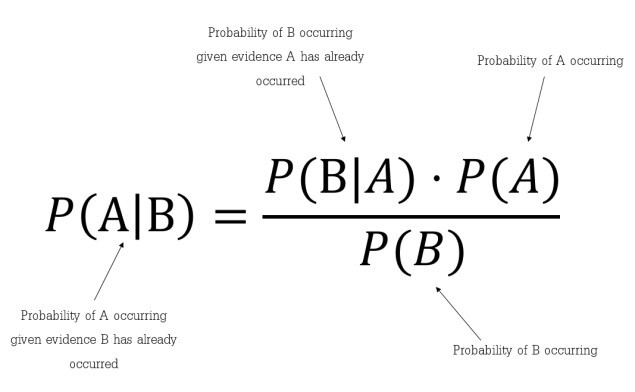




If we apply it to our work, it will be:
* **Posterior Probability ( P(A|B) ) = Probability of data being spam and probability of data being real.**
* **Likelihood ( P(B|A) ) = Probability of spam mails being data.**
* **Class Prior Probability ( P(A) ) = Probability of class being spam**

And naive bayes algorithm computes probabilities using bayes theorem. Naive Bayes algorithm is a lazy algorithm. You don't train them because they don't have something you can train (like a line or a neuron) so preparing it takes very short time.

Naive Bayes computes probabilities and chooses the best probability. Although Naive Bayes is a good and fast classifier, it has a real problem: **Zero Frequency**

Let's take a look at the formula again: Especially at the Likelihood. We said **probability of spam mails being data**. Data includes feature (we'll use bag of words technique, so each feature will be a word) and if a feature has a value that not occured in the data, its probability will be **zero** (impossible) There are techniques to prevent this problem but we won't need them.

And now we can start to implement, we'll use SKlearn and in the end of this kernel I will show you how to save a sklearn model to disk.


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import re
import nltk
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

* We have tree datasets that contains spam and ham mails. Let's clear and concatenate them.

In [ ]:
data1 = pd.read_csv('/kaggle/input/email-spam-dataset/lingSpam.csv')
data2 = pd.read_csv('/kaggle/input/email-spam-dataset/enronSpamSubset.csv')
data3 = pd.read_csv('/kaggle/input/email-spam-dataset/completeSpamAssassin.csv')

data1.head()


In [ ]:
data2.head()


In [ ]:
data3.head()

* In these datasets spam's label is 1 and ham's label is 0

In [ ]:
data1.drop("Unnamed: 0",inplace=True,axis=1)
data2.drop(["Unnamed: 0","Unnamed: 0.1"],inplace=True,axis=1)
data3.drop("Unnamed: 0",inplace=True,axis=1)

data2.head()

* Now we can concatenate them.

In [ ]:
data = pd.concat([data1,data2,data3],axis=0)
data.head()

In [ ]:
data.info()

* There is a missing value in the body texts, we should remove it.

In [ ]:
data.dropna(inplace=True)
data.info()

# Cleaning and Preparing Text

Now let's clean and prepare the text in order to use in Naive Bayes. We will follow these stpes:

* Cleaning links
* Cleaning digits except alphabetical and numerical characters.
* Lowering
* Tokenizing
* Lemmatizing and Removing Stopwords
* Bag of Words


## Cleaning Links
As you can predict, there are links in a mails such as: **https://google.com.tr** If we don't remove them they can cause problems (problems might be small but we don't want problems in here :D )

In order to clean links we will use regex (regular expressions) I will explain it.

In [ ]:
x = data["Body"]
x_clnd_link = [re.sub(r"http\S+", "", text) for text in x]

print(x_clnd_link[0])

* As you can see there is no link.

## Cleaning Digits Except Alphabetical and Numerical Characters
As you can see from the text above, there are a lot of digits such as <span style="font-weight:bold; font-size:14px;">* and : </span> They don't have a meaning, so we should remove them from the texts.

In order to clean unrelevant digits we'll use regex again.

In [ ]:
pattern = "[^a-zA-Z0-9]"


* This pattern means remove everything except alphabetical and numerical digits.

In [ ]:
# This means replace all the chars that follow the pattern 
x_cleaned = [re.sub(pattern," ",text) for text in x_clnd_link]


**Now let's lower the texts, I won't add a section for it because it is a familiar process from the vanilla python.**

In [ ]:
x_lowered = [text.lower() for text in x_cleaned]
print(x_lowered[0])

## Tokenizing 
In order to create a feature that shows whether the text includes the word or not, we need to split words into lists, we can do this using **pythonString.split()** but there is a better function to do this in NLTK. 

Let's tokenize the texts.

In [ ]:
x_tokenized = [nltk.word_tokenize(text) for text in x_lowered]


In [ ]:
print(x_tokenized[0])

* Each sentence turned into a list that contains words.

## Lemmatizing and Removing Stopwords
In natural languages, words can get additional so each word can have a lot of versions, sometimes these additionals may give tips to us but in filtering spams, we don't need them

There are two ways to remove additionals: **Stemmers and Lemmatizers**

### Stemmers
Stemmers are rule based weak tools, they remove additionals using rules but in natural languages everything does not follow the rules. Also It cant change tenses, for instance lemmatizers convert **learnt** into learn, stemmers don't touch them. Although stemmers are weak they are fast and although so many natural language do not have lemmatizers most of them have stemmers.

### Lemmatizers
Lemmatizers uses dictionaries to remove additionals and change tenses. They work good but developing a lemmatizer is hard and needs a lot of resource, so they are rare. Also lemmatizers use dictionaries, and that causes lemmatizers being slow.

In this kernel we'll use NLTK's WordNet Lemmatizer. WordNet is a big dictionary.


In [ ]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()

* Now we can use this lemmatizer easily, let's take a look at that.

In [ ]:
words = ["bats","removed","cheers","good","stopped","went","fired","cleaner","beers"]
for word in words:
    print(lemma.lemmatize(word),end=" ")

* Now we can lemmatize our texts.

In [ ]:
x_lemmatized = [[lemma.lemmatize(word) for word in text] for text in x_tokenized]


* We've used a really goood nested list comprehension

In [ ]:
print(x_lemmatized[0])

### Removing Stopwords
In natural languages there are words that not have a special meaning such as **will**, it is always a tense and such as **and,or**

In order to win from time and improve the model we should remove them. There are several ways to remove them but in this kernel we'll use stopwords corpora of NLTK. There are stopwords of 11 natural language in there.

In [ ]:
stopwords = nltk.corpus.stopwords.words("english")
x_prepared = [[word for word in text if word not in stopwords] for text in x_lemmatized]

In [ ]:
print(x_prepared[0])

* Now let's take a look at how many unique words we have in our dataset

In [ ]:
len(np.unique([word for text in x_prepared for word in text]))


(This looks a bit wrong, if you can see please help me in comment section)

## Bag of Words
And we came to the final process of this section: Bag of Words. Bag of Words is an easy approach to make sense of texts.
In order to explain it I'll give an example


        =======TEXTS======           WE HAVE SOME WORD HELLO WORLD FROM PYTHON I APPLE LOVE                
        We have some words           1   1    1    1     0    0     0    0     0   0    0
        Hello world from Python      0   0    0    0     1    1     1    1     0   0    0
        Hello I have some apples     0   1    1    0     1    0     0    0     1   1    0
        I love the world             0   0    0    0     0    1     0    0     1   0    1
   
 
In bag of words approach, each feature shows whether the text contains the word or not.
Now let's do it.

In [ ]:
vectorizer = CountVectorizer(max_features=20000)
x = vectorizer.fit_transform([" ".join(text) for text in x_prepared]).toarray()



In [ ]:
x.shape

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,np.asarray(data["Label"]),random_state=42,test_size=0.2)
x_train.shape

* Now everything is ready, we can fit our model!

# Naive Bayes Model
In this section we'll fit naive bayes model and prepare our spam filter.

In [ ]:
start_time = time.time()
NB = GaussianNB()
NB.fit(x_train,y_train)
end_time = time.time()

print(round(end_time-start_time,2))

* We have 18000 entries with 5000 feature data and it just took 3 seconds!

* Now let's take a look at the accuracy and confusion matrix

In [ ]:
NB.score(x_test,y_test)

* As you can see, we trained a model in just 3 seconds and its accuracy is %82.

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = NB.predict(x_test)

conf = confusion_matrix(y_pred=y_pred,y_true=y_test)
import seaborn
seaborn.heatmap(conf,annot=True,fmt=".1f",linewidths=1.5)
import matplotlib.pyplot as plt
plt.show()

# EXTRA: How to Save and Deploy The Model
In this extra section I will show you how to save and deploy your sklearn model using pickle.

Pickle is the easiest way of saving a python object

In [ ]:
import pickle
# We will save count vectorizer and model
with open("model.pckl",mode="wb") as F:
    pickle.dump(NB,F)
    
with open("vectorizer.pckl",mode="wb") as F:
    pickle.dump(vectorizer,F)

* And in order to deploy model we can define a function

In [ ]:
def predict_mail(mail):
    
    model = pickle.load(open("model.pckl",mode="rb"))
    vectorizer = pickle.load(open("vectorizer.pckl",mode="rb"))
    
    lemma = WordNetLemmatizer()
    
    stopwords = nltk.corpus.stopwords.words('english')
    
    mail = re.sub(r"http\S+", "", mail)
    mail = re.sub("[^a-zA-Z0-9]"," ",mail)
    mail = mail.lower()
    mail = nltk.word_tokenize(mail)
    mail = [lemma.lemmatize(word) for word in mail]
    mail = [word for word in mail if word not in stopwords]
    mail = " ".join(mail)
    
    vector = vectorizer.transform([mail])
    decision = model.predict(vector.toarray())
    
    return decision[0]
    
    

In [ ]:
predict_mail("Flash sale: you can buy a laptop just with one dollar")

# Conclusion
In this kernel I showed how to develop a spam filter model using Naive Bayes lazy ml algorithm. If you have questions in your mind, please ask in comment section. And if you liked this kernel please do upvote.

Have a great day!